In [1]:
import torch
import pickle as pkl
import numpy as np
import sys
from data_loader.datasets import DriveDataset
from skimage.filters import frangi
from sklearn import metrics
from matplotlib import pyplot as plt
import argparse
import cv2
%pylab
%matplotlib inline
from sklearn import metrics as M

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
filename = 'vesselness.pkl'
with open(filename, 'rb') as fi:
    vessels = pkl.load(fi)
    
with open('analysis.pkl', 'rb') as fi:
    data = torch.load(fi)

In [8]:
dataset = DriveDataset( "/pghbio/dbmi/batmanlab/rohit33/DRIVE/", train=True, augment=False)
gtdataset = DriveDataset( "/pghbio/dbmi/batmanlab/rohit33/DRIVE/", train=True, toy=True, augment=False)

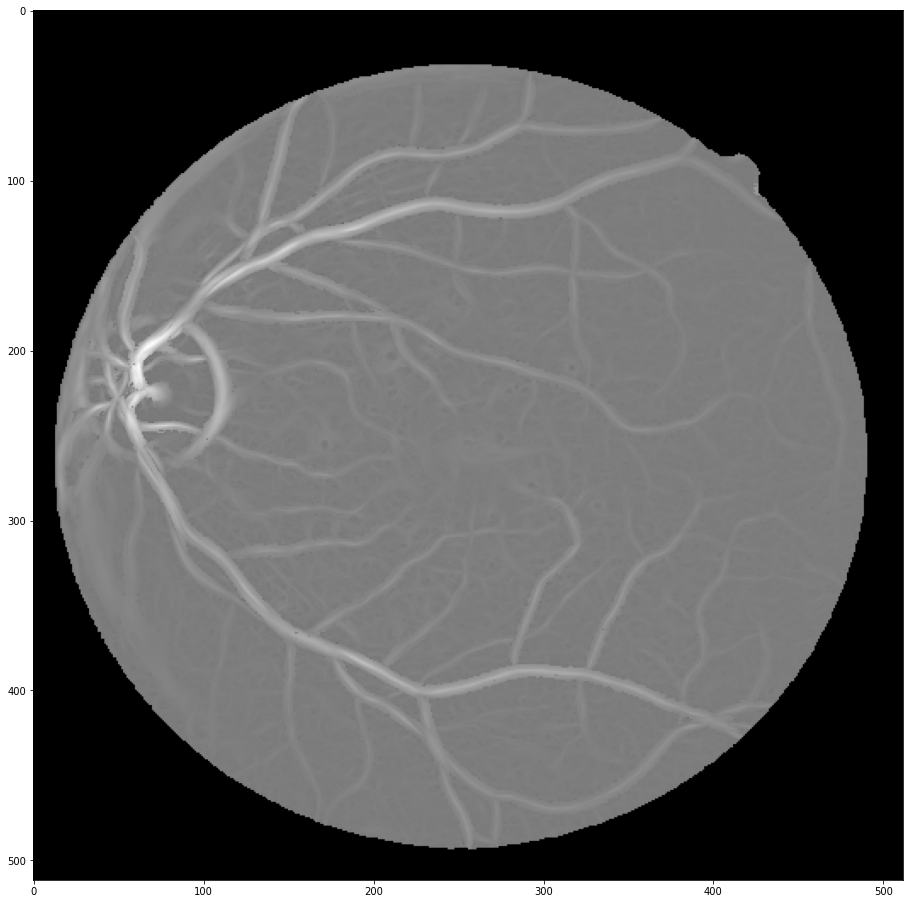

In [9]:
plt.figure(figsize=(16, 16))
plt.imshow(vessels[0, 0], 'gray')

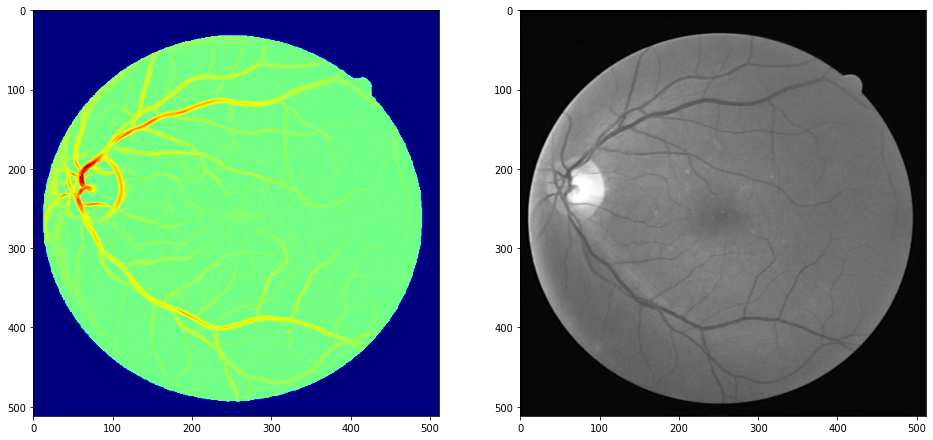

In [21]:
plt.figure(figsize=(16, 16))
I = 0
for i in range(I, I+1):
    img = dataset[i]['image'][0].data.cpu().numpy()
    lab = gtdataset[i]['image'][0].data.cpu().numpy()
    lab = (lab > 0.5).astype(int)
    mask = dataset[i]['mask'][0].data.cpu().numpy()
    # Get vesselness
#     ves = frangi_vesselness(img, i)
    ves = vessels[i, 0]
    ves = (ves - ves.min())/(ves.max() - ves.min())
#     ves = ves * mask
    plt.subplot(121)
    plt.imshow(ves, 'jet')
    plt.subplot(122)
    plt.imshow(img, 'gray')
#     plt.imshow(ves**(0.5), 'jet')
#     plt.imshow(ves > np.percentile(ves, 90))
    # plt.savefig('label.png')
#     auc = AUC(ves, lab)
#     print(auc)


In [22]:
def dice_score(a, b):
    num = 2*a*b
    den = a.sum() + b.sum()
    return num.sum() / den

In [23]:
fpr, tpr, thres = M.roc_curve(lab.reshape(-1), ves.reshape(-1), pos_label=1)
auc = M.auc(fpr, tpr)
print(auc)

0.9516210596765617


In [24]:
dice = []
for t in thres:
    vthres = (ves > t).astype(float)
    # Given thresholded image, get dice score
    d = dice_score(vthres, lab)
    dice.append(d)

In [25]:
max_idx = np.argmax(dice)
max_thres = thres[max_idx]
max_d = dice[max_idx]
print("Maximum dice score: {} achieved at threshold = {}".format(max_d, max_thres))

acc = ((ves > max_thres) == lab).mean()
print("Accuracy: {}".format(acc))

Maximum dice score: 0.6564225168441643 achieved at threshold = 0.5231614112854004
Accuracy: 0.939697265625


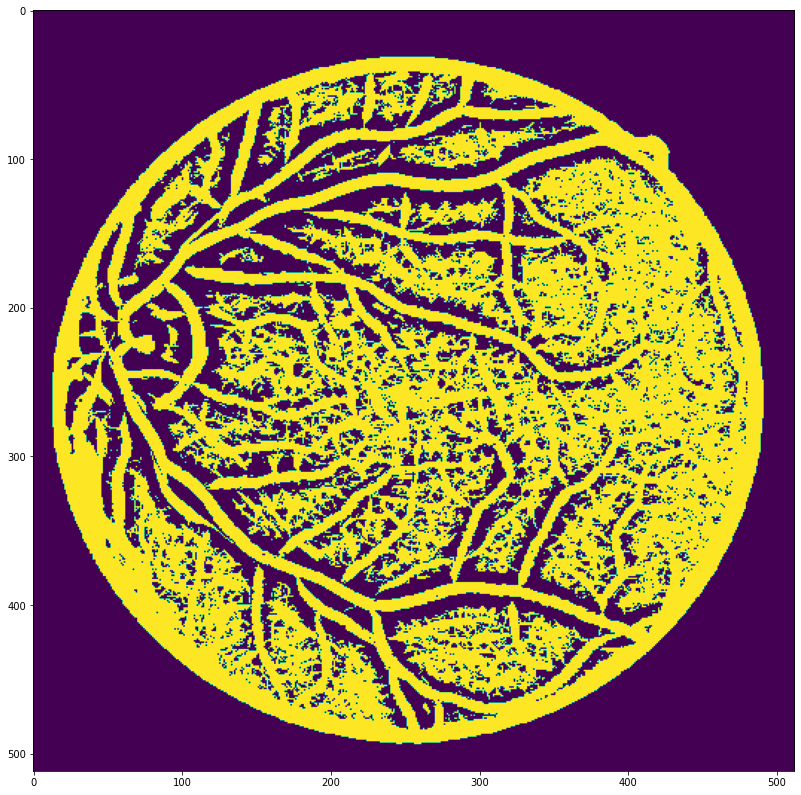

In [57]:
plt.figure(figsize=(14, 14))
vest = (ves*255).astype(np.uint8)
vest = cv2.adaptiveThreshold(vest, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 2)
plt.imshow(vest*mask)
# plt.imshow(ves > 0.55)